In [47]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms

from hmog import HmogHelper
from tqdm import tqdm

dataset_path = 'preprocessed_data/'

In [2]:
WINDOW_SIZE = 40000  # ms
WINDOW_SIZES = [20000, 40000, 60000, 80000, 100000, 120000, 140000]

In [48]:
class SimpleNeuralNet(nn.Module):
    def __init__(self) -> None:
        super(SimpleNeuralNet, self).__init__()

        input_shape = 64

        self.fc1 = nn.Linear(input_shape, 32)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=32, out_features=16)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(in_features=16, out_features=1)
        self.out = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu1(x)
        x = self.fc2(x)
        x = self.relu2(x)
        x = self.fc3(x)
        x = self.out(x)

        return x

In [49]:
class MyDataset(Dataset):
    def __init__(self, X, y, transform=None):
        # self.dataset = np.load(file_path)
        self.X = X
        self.y = y
        self.transform = transform
        
        # self.X = self.dataset[:, 1:-1]
        # self.y = self.dataset[:, -1]
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        # if self.transform is not None:
        #     curr_item_x = self.transform(self.X[idx])
        #     curr_item_y = self.transform(self.y[idx])
        #     
        #     return curr_item_x, curr_item_y
    
        return self.X[idx], self.y[idx]

In [50]:
from sklearn.model_selection import train_test_split

whole_dataset = np.load(os.path.join(dataset_path, 'hmog_vectors_with_labels.npy'))
whole_dataset = whole_dataset.astype(np.float32)
X, y = whole_dataset[:, 1:-1], whole_dataset[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# transform = transforms.Compose([transforms.ToTensor()])

train_dataset = MyDataset(X_train, y_train, transform=None)
val_dataset = MyDataset(X_val, y_val, transform=None)
test_dataset = MyDataset(X_test, y_test, transform=None)

print(len(train_dataset), len(val_dataset), len(test_dataset))

333997 83500 104375


In [51]:
def train_one_epoch(model, dataloader, loss_fn, device):
    running_loss = 0.
    last_loss = 0.
    
    model.train()

    for i, data in enumerate(dataloader):
        inputs, labels = data
        inputs, labels = inputs.to(device, dtype=torch.float32), labels.to(device, dtype=torch.float32)

        optimizer.zero_grad()

        outputs = model(inputs).reshape(-1)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        if i % 1000 == 999:
            last_loss = running_loss / 1000 # loss per batch
            print('  batch {} loss: {}'.format(i + 1, last_loss))
            running_loss = 0.

    return last_loss

In [52]:
model = SimpleNeuralNet()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-2)

In [53]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [54]:
EPOCHS = 50

vlosses = []
tlosses = []

In [55]:
for epoch in tqdm(range(EPOCHS)):
    avg_loss = train_one_epoch(model, train_dataloader, criterion, device)
    tlosses.append(avg_loss)

    running_vloss = 0.0

    model.eval()

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for i, vdata in enumerate(val_dataloader):
            vinputs, vlabels = vdata
            vinputs, vlabels = vinputs.to(device, dtype=torch.float32), vlabels.to(device, dtype=torch.float32)
            
            voutputs = model(vinputs).reshape(-1)
            vloss = criterion(voutputs, vlabels)
            running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    vlosses.append(avg_vloss)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

  0%|          | 0/50 [00:00<?, ?it/s]

  batch 1000 loss: 36.41809907722473
  batch 2000 loss: 27.948796075105665
  batch 3000 loss: 3.615182898759842
  batch 4000 loss: 0.7452625122666359
  batch 5000 loss: 0.6839453160762787


  2%|▏         | 1/50 [00:02<01:40,  2.05s/it]

LOSS train 0.6839453160762787 valid 0.6646052002906799
  batch 1000 loss: 0.6789466724991798
  batch 2000 loss: 0.6768145139813423
  batch 3000 loss: 0.6895702987909317
  batch 4000 loss: 0.6574310103058815
  batch 5000 loss: 0.6574597347676754


  4%|▍         | 2/50 [00:04<01:38,  2.05s/it]

LOSS train 0.6574597347676754 valid 0.6390221118927002
  batch 1000 loss: 0.6443125272989273
  batch 2000 loss: 0.6373988445997238
  batch 3000 loss: 0.6323159258663654
  batch 4000 loss: 0.6279588050544261
  batch 5000 loss: 0.6406193384826183


  6%|▌         | 3/50 [00:06<01:35,  2.04s/it]

LOSS train 0.6406193384826183 valid 0.6517730355262756
  batch 1000 loss: 0.6332499518096447
  batch 2000 loss: 0.6169333235025406
  batch 3000 loss: 0.6436504198908806
  batch 4000 loss: 0.6185499712824821
  batch 5000 loss: 0.6037120087146759


  8%|▊         | 4/50 [00:08<01:34,  2.04s/it]

LOSS train 0.6037120087146759 valid 0.5910869240760803
  batch 1000 loss: 0.6266775194108486
  batch 2000 loss: 0.6041645354628563
  batch 3000 loss: 0.5969881172478199
  batch 4000 loss: 0.6016825985908508
  batch 5000 loss: 0.6248319106698036


 10%|█         | 5/50 [00:10<01:31,  2.04s/it]

LOSS train 0.6248319106698036 valid 0.5915687680244446
  batch 1000 loss: 0.5957340249717236
  batch 2000 loss: 0.595986789226532
  batch 3000 loss: 0.5890810223519802
  batch 4000 loss: 0.5938369844257831
  batch 5000 loss: 0.588358979344368


 12%|█▏        | 6/50 [00:12<01:29,  2.03s/it]

LOSS train 0.588358979344368 valid 0.5832543969154358
  batch 1000 loss: 0.6093230438828469
  batch 2000 loss: 0.5987659994661808
  batch 3000 loss: 0.5913154789209366
  batch 4000 loss: 0.587076786339283
  batch 5000 loss: 0.5856740944087505


 14%|█▍        | 7/50 [00:14<01:26,  2.02s/it]

LOSS train 0.5856740944087505 valid 0.586268961429596
  batch 1000 loss: 0.5851316582262516
  batch 2000 loss: 0.5925964143872261
  batch 3000 loss: 0.6142523686289787
  batch 4000 loss: 0.5852187072634697
  batch 5000 loss: 0.5822859950065613


 16%|█▌        | 8/50 [00:16<01:24,  2.01s/it]

LOSS train 0.5822859950065613 valid 0.5968285202980042
  batch 1000 loss: 0.5861782364547252
  batch 2000 loss: 0.59801093262434
  batch 3000 loss: 0.5847398765981198
  batch 4000 loss: 0.597551816046238
  batch 5000 loss: 0.5783714305460453


 18%|█▊        | 9/50 [00:18<01:22,  2.01s/it]

LOSS train 0.5783714305460453 valid 0.5698497891426086
  batch 1000 loss: 0.5781704180538655
  batch 2000 loss: 0.5824952980577945
  batch 3000 loss: 0.5792342800498008
  batch 4000 loss: 0.5782289905846119
  batch 5000 loss: 0.5900506750047206


 20%|██        | 10/50 [00:20<01:20,  2.00s/it]

LOSS train 0.5900506750047206 valid 0.5703784227371216
  batch 1000 loss: 0.5741643636524677
  batch 2000 loss: 0.5816315394639969
  batch 3000 loss: 0.5805751389861107
  batch 4000 loss: 0.5835926769375801
  batch 5000 loss: 0.5796174561977386


 22%|██▏       | 11/50 [00:22<01:18,  2.00s/it]

LOSS train 0.5796174561977386 valid 0.5819900631904602
  batch 1000 loss: 0.5721714676618576
  batch 2000 loss: 0.6027667398750782
  batch 3000 loss: 0.5969076517522335
  batch 4000 loss: 0.577625771254301
  batch 5000 loss: 0.580996353983879


 24%|██▍       | 12/50 [00:24<01:15,  2.00s/it]

LOSS train 0.580996353983879 valid 0.5691824555397034
  batch 1000 loss: 0.5863154865801334
  batch 2000 loss: 0.573895112812519
  batch 3000 loss: 0.5752874546945095
  batch 4000 loss: 0.5685093669593334
  batch 5000 loss: 0.582647865921259


 26%|██▌       | 13/50 [00:26<01:13,  1.99s/it]

LOSS train 0.582647865921259 valid 0.5679048895835876
  batch 1000 loss: 0.5784806723296643
  batch 2000 loss: 0.5651374751627445
  batch 3000 loss: 0.5750837364196777
  batch 4000 loss: 0.5697985544204712
  batch 5000 loss: 0.5752321827411652


 28%|██▊       | 14/50 [00:28<01:11,  1.99s/it]

LOSS train 0.5752321827411652 valid 0.5595802068710327
  batch 1000 loss: 0.5691379165649414
  batch 2000 loss: 0.573253270894289
  batch 3000 loss: 0.5831503159105778
  batch 4000 loss: 0.5822561088502407
  batch 5000 loss: 0.575528960287571


 30%|███       | 15/50 [00:30<01:09,  1.99s/it]

LOSS train 0.575528960287571 valid 0.5618846416473389
  batch 1000 loss: 0.5756742421984673
  batch 2000 loss: 0.5760449088215828
  batch 3000 loss: 0.5759307698011399
  batch 4000 loss: 0.5749922812581062
  batch 5000 loss: 0.575862165749073


 32%|███▏      | 16/50 [00:32<01:08,  2.00s/it]

LOSS train 0.575862165749073 valid 0.5926386117935181
  batch 1000 loss: 0.5741322565078736
  batch 2000 loss: 0.5713779191076755
  batch 3000 loss: 0.5720280740559102
  batch 4000 loss: 0.568560770213604
  batch 5000 loss: 0.5690095643103122


 34%|███▍      | 17/50 [00:34<01:07,  2.04s/it]

LOSS train 0.5690095643103122 valid 0.5961877107620239
  batch 1000 loss: 0.5700817647874356
  batch 2000 loss: 0.5745948434770107
  batch 3000 loss: 0.5782759656310081
  batch 4000 loss: 0.5772145534455776
  batch 5000 loss: 0.571998302012682


 36%|███▌      | 18/50 [00:36<01:06,  2.09s/it]

LOSS train 0.571998302012682 valid 0.5526430606842041
  batch 1000 loss: 0.5674771989285946
  batch 2000 loss: 0.5689438644051552
  batch 3000 loss: 0.5680805283784867
  batch 4000 loss: 0.5677449524998665
  batch 5000 loss: 0.5671061726808548


 38%|███▊      | 19/50 [00:38<01:05,  2.11s/it]

LOSS train 0.5671061726808548 valid 0.5778178572654724
  batch 1000 loss: 0.5666551088690758
  batch 2000 loss: 0.5748038638234139
  batch 3000 loss: 0.563599743694067
  batch 4000 loss: 0.574173686772585
  batch 5000 loss: 0.5791587119102478


 40%|████      | 20/50 [00:40<01:02,  2.07s/it]

LOSS train 0.5791587119102478 valid 0.5674872994422913
  batch 1000 loss: 0.5699483308494091
  batch 2000 loss: 0.5726742132008076
  batch 3000 loss: 0.5735630622804165
  batch 4000 loss: 0.5640916861891746
  batch 5000 loss: 0.566365217089653


 42%|████▏     | 21/50 [00:42<00:59,  2.05s/it]

LOSS train 0.566365217089653 valid 0.5759540796279907
  batch 1000 loss: 0.5841075601875783
  batch 2000 loss: 0.5644246281683445
  batch 3000 loss: 0.5797314913570881
  batch 4000 loss: 0.5742568481564522
  batch 5000 loss: 0.5850521195828915


 44%|████▍     | 22/50 [00:44<00:56,  2.03s/it]

LOSS train 0.5850521195828915 valid 0.5703972578048706
  batch 1000 loss: 0.5726979361176491
  batch 2000 loss: 0.5669172618091106
  batch 3000 loss: 0.5638266468942166
  batch 4000 loss: 0.5723439079225063
  batch 5000 loss: 0.5685071401298046


 46%|████▌     | 23/50 [00:46<00:54,  2.02s/it]

LOSS train 0.5685071401298046 valid 0.5529460310935974
  batch 1000 loss: 0.5740580953359604
  batch 2000 loss: 0.5749364000856876
  batch 3000 loss: 0.5708941541612148
  batch 4000 loss: 0.5633020416796207
  batch 5000 loss: 0.5752294470071793


 48%|████▊     | 24/50 [00:48<00:52,  2.01s/it]

LOSS train 0.5752294470071793 valid 0.5618009567260742
  batch 1000 loss: 0.5693065085709095
  batch 2000 loss: 0.5719504598379135
  batch 3000 loss: 0.5630172814726829
  batch 4000 loss: 0.5684491637051106
  batch 5000 loss: 0.5667802141010762


 50%|█████     | 25/50 [00:50<00:49,  2.00s/it]

LOSS train 0.5667802141010762 valid 0.5790973901748657
  batch 1000 loss: 0.562828193128109
  batch 2000 loss: 0.5596194461882115
  batch 3000 loss: 0.5603420694768428
  batch 4000 loss: 0.5585502778291702
  batch 5000 loss: 0.5667554311156273


 52%|█████▏    | 26/50 [00:52<00:47,  2.00s/it]

LOSS train 0.5667554311156273 valid 0.7351303100585938
  batch 1000 loss: 0.5697817721366882
  batch 2000 loss: 0.5789037924110889
  batch 3000 loss: 0.5669606871306896
  batch 4000 loss: 0.5791134058833122
  batch 5000 loss: 0.5660126565396786


 54%|█████▍    | 27/50 [00:54<00:46,  2.04s/it]

LOSS train 0.5660126565396786 valid 0.5506554245948792
  batch 1000 loss: 0.5613055201768875
  batch 2000 loss: 0.5690643540024758
  batch 3000 loss: 0.5585772581398487
  batch 4000 loss: 0.5720209295749664
  batch 5000 loss: 0.5645320459604263


 56%|█████▌    | 28/50 [00:56<00:44,  2.04s/it]

LOSS train 0.5645320459604263 valid 0.5562395453453064
  batch 1000 loss: 0.5646897056400776
  batch 2000 loss: 0.5662479896247387
  batch 3000 loss: 0.5657801809608937
  batch 4000 loss: 0.5702260447740555
  batch 5000 loss: 0.574409756153822


 58%|█████▊    | 29/50 [00:58<00:42,  2.03s/it]

LOSS train 0.574409756153822 valid 0.5557798147201538
  batch 1000 loss: 0.57243856087327
  batch 2000 loss: 0.5620973455011845
  batch 3000 loss: 0.5782946257591247
  batch 4000 loss: 0.5648385938107967
  batch 5000 loss: 0.5676420566737652


 60%|██████    | 30/50 [01:00<00:40,  2.02s/it]

LOSS train 0.5676420566737652 valid 0.5558497309684753
  batch 1000 loss: 0.5736682212352753
  batch 2000 loss: 0.5722423889636994
  batch 3000 loss: 0.5601653560996056
  batch 4000 loss: 0.5636809817254543
  batch 5000 loss: 0.564550389200449


 62%|██████▏   | 31/50 [01:02<00:38,  2.03s/it]

LOSS train 0.564550389200449 valid 0.5703163146972656
  batch 1000 loss: 0.5708140480220318
  batch 2000 loss: 0.5704156759083271
  batch 3000 loss: 0.5645386962890625
  batch 4000 loss: 0.5651016384959221
  batch 5000 loss: 0.5592395927906036


 64%|██████▍   | 32/50 [01:04<00:36,  2.03s/it]

LOSS train 0.5592395927906036 valid 0.5440852642059326
  batch 1000 loss: 0.5604749249815941
  batch 2000 loss: 0.5653208436667919
  batch 3000 loss: 0.5728795428872109
  batch 4000 loss: 0.5615573778152466
  batch 5000 loss: 0.5688387146294117


 66%|██████▌   | 33/50 [01:06<00:34,  2.01s/it]

LOSS train 0.5688387146294117 valid 0.55072420835495
  batch 1000 loss: 0.5694520787000656
  batch 2000 loss: 0.570517842233181
  batch 3000 loss: 0.5631146918833255
  batch 4000 loss: 0.5610545372366905
  batch 5000 loss: 0.5681851657032967


 68%|██████▊   | 34/50 [01:08<00:32,  2.00s/it]

LOSS train 0.5681851657032967 valid 0.6064959168434143
  batch 1000 loss: 0.5678450074791909
  batch 2000 loss: 0.5620173095464707
  batch 3000 loss: 0.5743327096402645
  batch 4000 loss: 0.5772778412401676
  batch 5000 loss: 0.5652740592956543


 70%|███████   | 35/50 [01:10<00:29,  2.00s/it]

LOSS train 0.5652740592956543 valid 0.5521460175514221
  batch 1000 loss: 0.5615539593994617
  batch 2000 loss: 0.5891418069303036
  batch 3000 loss: 0.5723853202164173
  batch 4000 loss: 0.5698015676736832
  batch 5000 loss: 0.5623556288778782


 72%|███████▏  | 36/50 [01:12<00:27,  1.99s/it]

LOSS train 0.5623556288778782 valid 0.5937184691429138
  batch 1000 loss: 0.565724851489067
  batch 2000 loss: 0.5496849291920662
  batch 3000 loss: 0.5712193385362625
  batch 4000 loss: 0.5643751475214959
  batch 5000 loss: 0.5571456639170647


 74%|███████▍  | 37/50 [01:14<00:25,  1.99s/it]

LOSS train 0.5571456639170647 valid 0.5623210072517395
  batch 1000 loss: 0.5667479055225849
  batch 2000 loss: 0.5723647346794605
  batch 3000 loss: 0.5510064264535904
  batch 4000 loss: 0.5643838679790497
  batch 5000 loss: 0.5585959254205227


 76%|███████▌  | 38/50 [01:16<00:23,  1.97s/it]

LOSS train 0.5585959254205227 valid 0.5474547147750854
  batch 1000 loss: 0.5644476904869079
  batch 2000 loss: 0.5623713338375091
  batch 3000 loss: 0.5598959361314774
  batch 4000 loss: 0.5472216420471668
  batch 5000 loss: 0.5626028057038784


 78%|███████▊  | 39/50 [01:18<00:21,  1.96s/it]

LOSS train 0.5626028057038784 valid 0.5637913942337036
  batch 1000 loss: 0.558138802409172
  batch 2000 loss: 0.5554434698224068
  batch 3000 loss: 0.5584542127549649
  batch 4000 loss: 0.5596131580471992
  batch 5000 loss: 0.5671464504897594


 80%|████████  | 40/50 [01:20<00:19,  1.95s/it]

LOSS train 0.5671464504897594 valid 0.5687897205352783
  batch 1000 loss: 0.5406404227614403
  batch 2000 loss: 0.5534272232055664
  batch 3000 loss: 0.5522225124835968
  batch 4000 loss: 0.5488935653865338
  batch 5000 loss: 0.5599785523116588


 82%|████████▏ | 41/50 [01:22<00:17,  1.94s/it]

LOSS train 0.5599785523116588 valid 0.5823489427566528
  batch 1000 loss: 0.5577781528234482
  batch 2000 loss: 0.5465623680949211
  batch 3000 loss: 0.5617183682024479
  batch 4000 loss: 0.547821004152298
  batch 5000 loss: 0.5577028715312481


 84%|████████▍ | 42/50 [01:24<00:15,  1.94s/it]

LOSS train 0.5577028715312481 valid 0.5699491500854492
  batch 1000 loss: 0.5536225248277188
  batch 2000 loss: 0.5563876155018807
  batch 3000 loss: 0.5478999235332013
  batch 4000 loss: 0.5546782800257206
  batch 5000 loss: 0.5627004577815533


 86%|████████▌ | 43/50 [01:26<00:13,  1.95s/it]

LOSS train 0.5627004577815533 valid 0.5958893299102783
  batch 1000 loss: 0.5591237082183361
  batch 2000 loss: 0.5667325429320336
  batch 3000 loss: 0.561227214127779
  batch 4000 loss: 0.547241114974022
  batch 5000 loss: 0.5576184107363225


 88%|████████▊ | 44/50 [01:28<00:11,  1.94s/it]

LOSS train 0.5576184107363225 valid 0.5301056504249573
  batch 1000 loss: 0.5650248272418976
  batch 2000 loss: 0.5445882753133774
  batch 3000 loss: 0.547801185876131
  batch 4000 loss: 0.5607924109101295
  batch 5000 loss: 0.5439663442075252


 90%|█████████ | 45/50 [01:30<00:09,  1.98s/it]

LOSS train 0.5439663442075252 valid 0.5532318949699402
  batch 1000 loss: 0.5441407297253609
  batch 2000 loss: 0.5410666007697582
  batch 3000 loss: 0.5712507494688034
  batch 4000 loss: 0.5616710513532162
  batch 5000 loss: 0.5478421508073806


 92%|█████████▏| 46/50 [01:32<00:08,  2.10s/it]

LOSS train 0.5478421508073806 valid 0.5471475124359131
  batch 1000 loss: 0.5570170058310032
  batch 2000 loss: 0.5469358794093132
  batch 3000 loss: 0.5341657963097095
  batch 4000 loss: 0.5566858224868775
  batch 5000 loss: 0.5533140361905098


 94%|█████████▍| 47/50 [01:34<00:06,  2.11s/it]

LOSS train 0.5533140361905098 valid 1.2557604312896729
  batch 1000 loss: 0.5447365599870682
  batch 2000 loss: 0.5445148205161094
  batch 3000 loss: 0.5533488782942295
  batch 4000 loss: 0.5545646080374718
  batch 5000 loss: 0.5784180454909802


 96%|█████████▌| 48/50 [01:37<00:04,  2.12s/it]

LOSS train 0.5784180454909802 valid 0.5323443412780762
  batch 1000 loss: 0.5759808647632599
  batch 2000 loss: 0.5750830145478248
  batch 3000 loss: 0.5545856524705887
  batch 4000 loss: 0.543021841198206
  batch 5000 loss: 0.5474943917095662


 98%|█████████▊| 49/50 [01:39<00:02,  2.13s/it]

LOSS train 0.5474943917095662 valid 0.5459854602813721
  batch 1000 loss: 0.5502831024825573
  batch 2000 loss: 0.5602373676896095
  batch 3000 loss: 0.54917129150033
  batch 4000 loss: 0.5437246811687946
  batch 5000 loss: 0.5620873155891896


100%|██████████| 50/50 [01:41<00:00,  2.03s/it]

LOSS train 0.5620873155891896 valid 0.5192235112190247


In [56]:
  # torch.save(model, 'classification_model_auc_0xx')

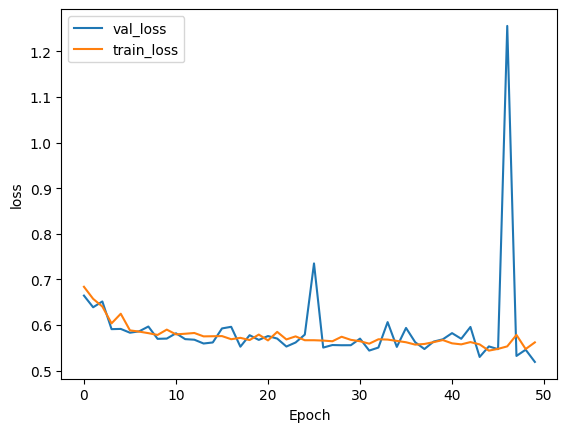

In [56]:
import matplotlib.pyplot as plt

vlosses_values = [t.item() for t in vlosses]
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.plot(range(EPOCHS), vlosses_values, label='val_loss')
plt.plot(range(EPOCHS), tlosses, label='train_loss')
plt.legend()

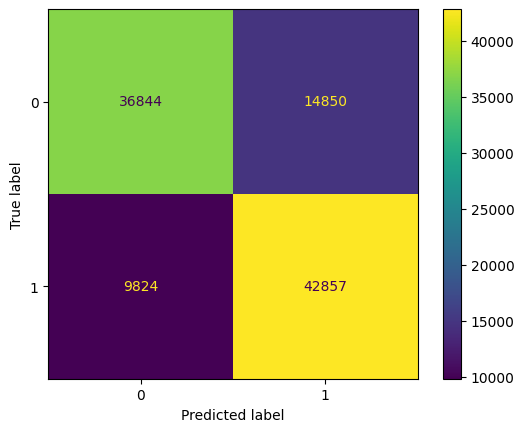

In [57]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay

# model = torch.load('classification_model_auc_083')
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_test_tensor = torch.from_numpy(X_test).float().to(device)
y_test = y_test.astype(dtype=np.int32)

with torch.no_grad():
    predictions = (model(X_test_tensor).reshape(-1)).cpu().detach().numpy()
    predictions_labels = [1 if p >= 0.5 else 0 for p in predictions]

cm = confusion_matrix(y_test, predictions_labels)
tn, fp, fn, tp = cm.ravel()

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()


In [58]:
auc = roc_auc_score(y_test, predictions)

In [59]:
print(auc)

0.8138806931676617


In [60]:
fpr, tpr, thresholds = roc_curve(y_test, predictions)

In [61]:
print(fpr, tpr, thresholds)

[0.         0.13299416 0.13299416 ... 0.99843309 0.99990328 1.        ] [0.         0.49091703 0.49093601 ... 1.         1.         1.        ] [          inf 7.7792710e-01 7.7792144e-01 ... 4.3074385e-13 1.3034530e-33
 0.0000000e+00]


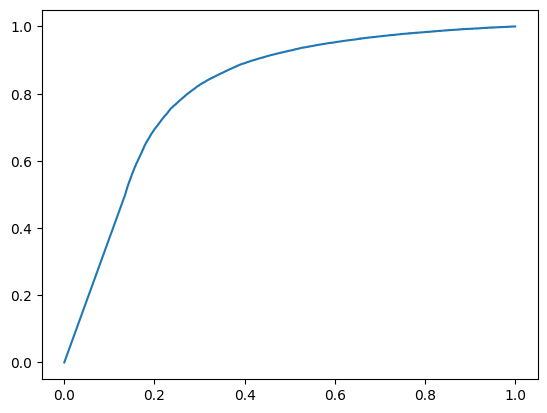

In [62]:
plt.plot(fpr, tpr)

In [86]:
unique, counts = np.unique(y_test, return_counts=True)

print(unique, counts)

[0 1] [51694 52681]


In [61]:
print(model)

SimpleNeuralNet(
  (fc1): Linear(in_features=64, out_features=32, bias=True)
  (relu1): ReLU()
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=16, out_features=1, bias=True)
  (out): Sigmoid()
)
